In [1]:
import matplotlib.pyplot as plt
from matplotlib import rc, animation
from matplotlib.lines import Line2D
from IPython.display import HTML, display, Image
import pandas as pd
import math
import datetime
import numpy as np
%matplotlib inline
pd.set_option('display.max_rows', None)

In [2]:
df = pd.read_csv('energy_demand.txt')

In [3]:
df.head()

C NEMP.WORLD LFCST_HISTDEMAND AEMO    PUBLIC           2018/12/02  \
0  I     DEMAND         HISTORIC    1  REGIONID       SETTLEMENTDATE   
1  D     DEMAND         HISTORIC    1      NSW1  2018/12/01 00:00:00   
2  D     DEMAND         HISTORIC    1      NSW1  2018/12/01 00:00:00   
3  D     DEMAND         HISTORIC    1      NSW1  2018/12/01 00:00:00   
4  D     DEMAND         HISTORIC    1      NSW1  2018/12/01 00:00:00   

   02:00:00 0000000301717790  Unnamed: 8  0000000301717789  
0  PERIODID           DEMAND         NaN               NaN  
1         1             7083         NaN               NaN  
2         2             6858         NaN               NaN  
3         3             6600         NaN               NaN  
4         4             6354         NaN               NaN

In [4]:
# drop useless columns
df = df.drop([df.columns[0],df.columns[1],df.columns[2],df.columns[3],df.columns[-2], df.columns[-1]], axis='columns')

In [5]:
df.head()

PUBLIC           2018/12/02  02:00:00 0000000301717790
0  REGIONID       SETTLEMENTDATE  PERIODID           DEMAND
1      NSW1  2018/12/01 00:00:00         1             7083
2      NSW1  2018/12/01 00:00:00         2             6858
3      NSW1  2018/12/01 00:00:00         3             6600
4      NSW1  2018/12/01 00:00:00         4             6354

In [6]:
# rename columns
df = df.rename(columns={'PUBLIC':'REGION', '2018/12/02':'DATE', '02:00:00':'HOUR', '0000000301717790':'MW'})

In [7]:
# remove dirty rows
df = df[df.REGION != 'REGION']
df = df[df.REGION != 'PUBLIC']
df = df[df.HOUR != 'HOUR']
df = df[df.MW != 'DEMAND']
df = df.dropna()

In [8]:
# convert columns from str to int
df['HOUR'] = df['HOUR'].astype(int)
df['HOUR'] = df['HOUR']/2
df['MW'] = df['MW'].astype(int)

In [9]:
# convert DATE from str to DATETIME
df['DATE'] = pd.to_datetime(df['DATE'], format='%Y/%m/%d %H:%M:%S')

In [10]:
# split into state df
NSW = df.loc[df['REGION'] == 'NSW1']
QLD = df.loc[df['REGION'] == 'QLD1']
SA = df.loc[df['REGION'] == 'SA1']
TAS = df.loc[df['REGION'] == 'TAS1']
VIC = df.loc[df['REGION'] == 'VIC1']

In [11]:
# sort by date and period
NSW = NSW.sort_values(by=['DATE', 'HOUR'])
QLD = QLD.sort_values(by=['DATE', 'HOUR'])
SA = SA.sort_values(by=['DATE', 'HOUR'])
TAS = TAS.sort_values(by=['DATE', 'HOUR'])
VIC = VIC.sort_values(by=['DATE', 'HOUR'])

#### Now to parse the surise and sunset times for 1/12/18 to 31/12/19

In [12]:
sun_times = open('sunrise_sunset_times.txt', 'r', encoding='utf-8').read()

In [13]:
sun_times = sun_times.splitlines()

In [14]:
import re

In [15]:
def times_strip(row):
    times = row[2:25] # splice first part of string
    times = re.findall(r'\d:\d\d', times) # find times 
    srise, sset = times[0], times[1] # assign variables
    srise, sset = srise.split(':'), sset.split(':') # split into hours and minutes
    srise = list(map(int, srise)) # convert all numbers from str to int
    sset = list(map(int, sset)) # convert all numbers from str to int
    srise[1] = srise[1]/60 # covert minutes to hours
    sset[0], sset[1] = sset[0]+12, sset[1]/60 # convert hours to 24 time, minutes to hours
    srise, sset = sum(srise), sum(sset) # sum each time into one
    
    day_length = row[25:50] # splice part of string containing day length
    day_length = re.findall(r'\d{1,2}:\d\d:\d\d', day_length) # find time
    hour, minute, second = day_length[0].split(':')
    hour, minute, second = int(hour), int(minute), int(second)
    minute, second = minute/60, second/3600
    daylight_hours = hour + minute + second
    
    
    return srise, sset, daylight_hours

In [16]:
'''
for each day on the year, strip the sunrise and sunset times, 
convert to 24 decimal time and add to year_times list
'''
year_times = []
for row in sun_times:
    if len(row) != 0:
        day_times = times_strip(row)
        year_times.append(day_times)

#### By calculating the area under the demand vs time graph, we can find the total energy used in MWh between 12:00am and midnight. 

In [17]:
def area_under(x1, y1, x2, y2):
    if y1 < y2:
        triangle = 0.5*(x2-x1)*(y2-y1) # half base x height
        rectangle = (x2-x1) * y1
        area = triangle + rectangle
        return area
    elif y1 > y2:
        triangle = 0.5*(x2-x1)*(y1-y2) # half base x height
        rectangle = (x2-x1) * y2
        area = triangle + rectangle
        return area
    elif y1 == y2:
        area = (x2-x1) * y2
        return area

In [18]:
days_energy = []
hhour_energy = [0]
day_areas = []
length = len(VIC)
i = 0
while i < length-1:
    x1 = VIC['HOUR'].iloc[i]
    x2 = VIC['HOUR'].iloc[i+1]
    y1 = VIC['MW'].iloc[i]
    y2 = VIC['MW'].iloc[i+1]
    if x1 != 24:
        area = area_under(x1,y1,x2,y2)
        day_areas.append(area)
    elif x1 == 24:
        day = VIC['DATE'].iloc[i]
        daily_energy = sum(day_areas)
        days_energy.append(daily_energy)
        day_areas = []
        x1 = 0
        area = area_under(x1,y1,x2,y2)
        day_areas.append(area)
    hhour_energy.append(area)   
    i += 1

Average total energy used per day:

In [19]:
ave = sum(days_energy)/len(days_energy)
print(ave)

118162.06898734177


Plot of total energy used per day:

In [20]:
dates = pd.unique(VIC['DATE'])
dates = dates[:-1]

d1 = datetime.datetime.strptime('01/12/18', '%d/%m/%y')
autumn = datetime.datetime.strptime('01/03/19', '%d/%m/%y')
winter = datetime.datetime.strptime('01/06/19', '%d/%m/%y')
spring = datetime.datetime.strptime('01/09/19', '%d/%m/%y')
summer = datetime.datetime.strptime('01/12/19', '%d/%m/%y')
d_last = datetime.datetime.strptime('29/12/19', '%d/%m/%y')

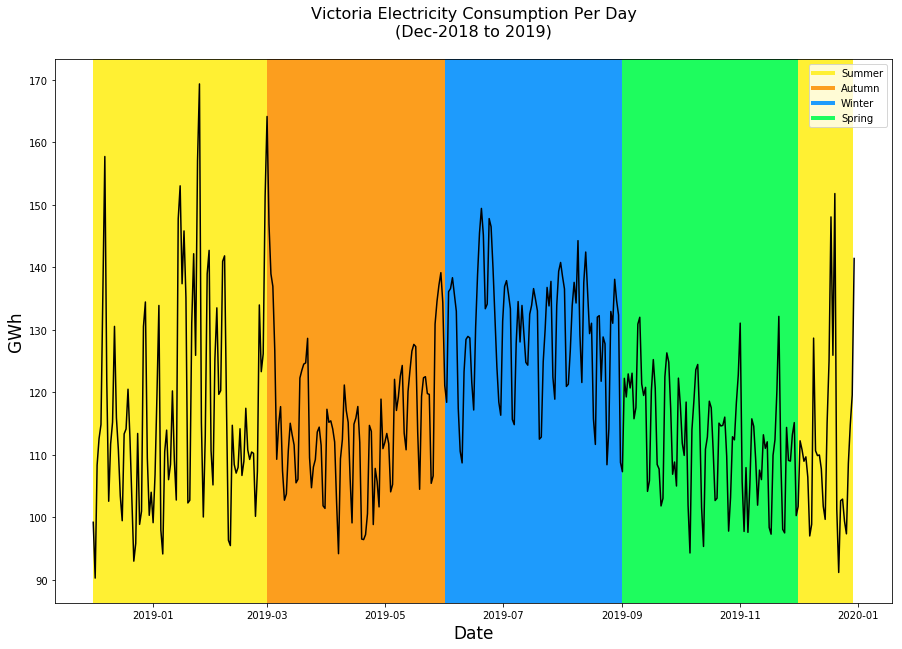

In [21]:
days_energy_GWh = [i/1000 for i in days_energy] # make list with GWh not MWh
plt.figure(figsize=(15,10))
plt.plot(dates, days_energy_GWh, color='black')
plt.title('Victoria Electricity Consumption Per Day\n(Dec-2018 to 2019)\n', size=16)
plt.xlabel('Date', size=17)
plt.ylabel('GWh', size=17)

plt.axvspan(d1, autumn, color='#FFF033')
plt.axvspan(autumn, winter, color='#FC9E1E')
plt.axvspan(winter, spring, color='#1E9BFC')
plt.axvspan(spring, summer, color='#1EFC5E')
plt.axvspan(summer, d_last, color='#FFF033')

legend_lines = [Line2D([0],[0], color='#FFF033', lw=4),
                Line2D([0],[0], color='#FC9E1E', lw=4),
                Line2D([0],[0], color='#1E9BFC', lw=4),
                Line2D([0],[0], color='#1EFC5E', lw=4)]
plt.legend(legend_lines, ['Summer', 'Autumn', 'Winter', 'Spring'])

Now to find the energy used between sunset and sunrise

In [38]:
nights_energy = []
night_areas = []
VIC_minus_half_first = VIC.iloc[24:] # drop first half of first day as I only have data for half that night
length = len(VIC)
i = 0
j = 0
while i < length-1 and j < len(year_times)-1:
    x1 = VIC_minus_half_first['HOUR'].iloc[i]
    x2 = VIC_minus_half_first['HOUR'].iloc[i+1]
    y1 = VIC_minus_half_first['MW'].iloc[i]
    y2 = VIC_minus_half_first['MW'].iloc[i+1]
    sunset = year_times[j][1]
    sunrise = year_times[j+1][0]
    if x1 == 24:
        x1 = 0
    if x1 > sunset or x2 < sunrise:
        area = area_under(x1,y1,x2,y2)
        night_areas.append(area)
    elif x1 > sunrise:
        if len(night_areas) > 0:
            n_energy = sum(night_areas)
            nights_energy.append(n_energy)
            night_areas = []
            j += 1
    i += 1
    print(i, end='\r')

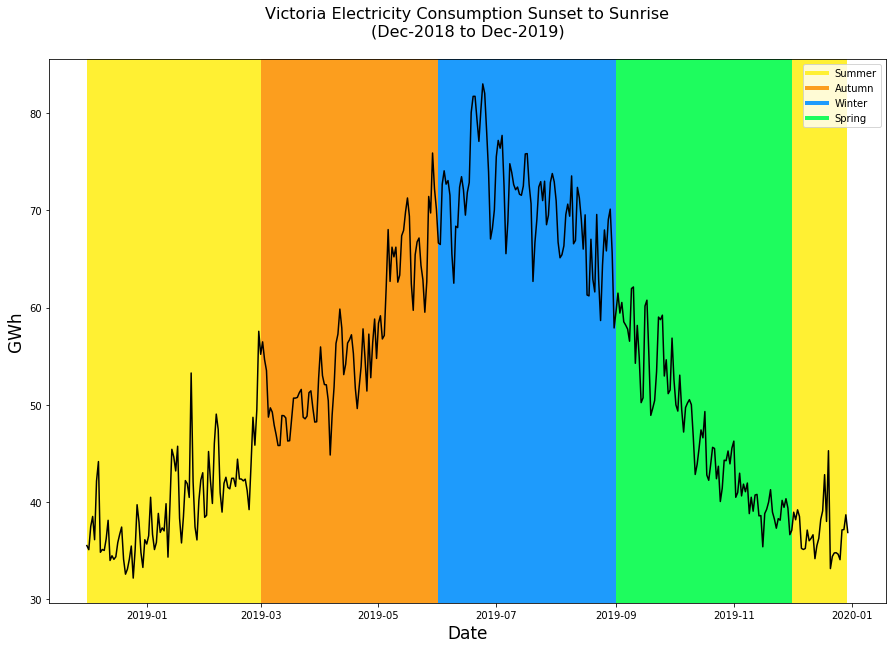

In [39]:
nights_energy_GWh = [i/1000 for i in nights_energy] # make list with GWh not MWh
plt.figure(figsize=(15,10))
plt.plot(dates, nights_energy_GWh, color='black')
plt.title('Victoria Electricity Consumption Sunset to Sunrise\n(Dec-2018 to Dec-2019)\n', size=16)
plt.xlabel('Date', size=17)
plt.ylabel('GWh', size=17)

plt.axvspan(d1, autumn, color='#FFF033')
plt.axvspan(autumn, winter, color='#FC9E1E')
plt.axvspan(winter, spring, color='#1E9BFC')
plt.axvspan(spring, summer, color='#1EFC5E')
plt.axvspan(summer, d_last, color='#FFF033')

legend_lines = [Line2D([0],[0], color='#FFF033', lw=4),
                Line2D([0],[0], color='#FC9E1E', lw=4),
                Line2D([0],[0], color='#1E9BFC', lw=4),
                Line2D([0],[0], color='#1EFC5E', lw=4)]
plt.legend(legend_lines, ['Summer', 'Autumn', 'Winter', 'Spring'])
plt.savefig('night_consumption')

In [40]:
day_lengths = [i[2] for i in year_times]
day_lengths = day_lengths[:-1]

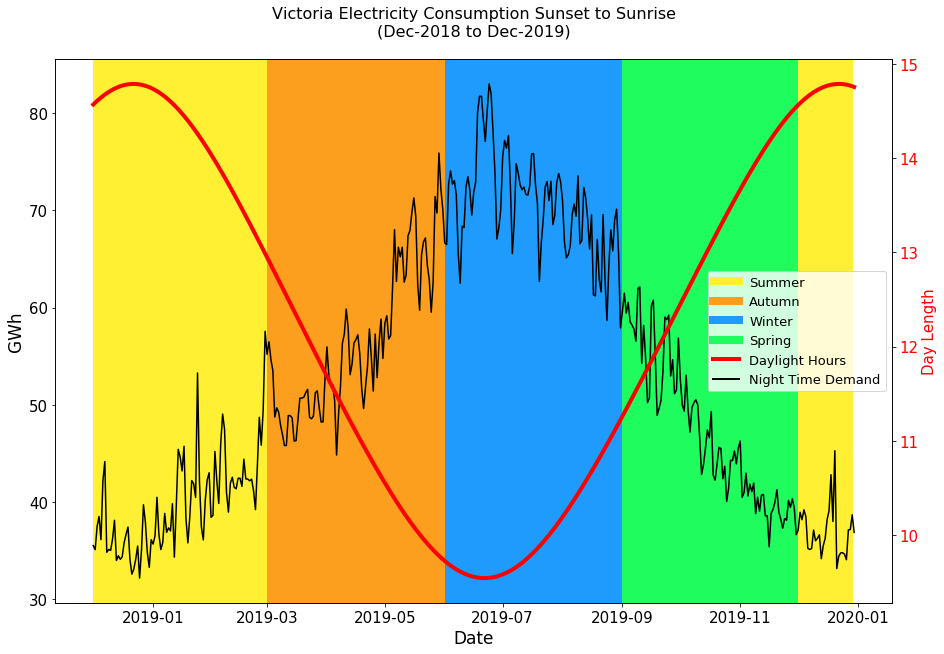

In [252]:
nights_energy_GWh = [i/1000 for i in nights_energy] # make list with GWh not MWh
fig, ax1 = plt.subplots()

fig.set_figheight(10)
fig.set_figwidth(15)

ax1.plot(dates, nights_energy_GWh, color='black')
ax1.set_title('Victoria Electricity Consumption Sunset to Sunrise\n(Dec-2018 to Dec-2019)\n', size=16)
ax1.set_xlabel('Date', size=17)
ax1.set_ylabel('GWh', size=17)
ax1.tick_params(axis='y', labelsize=15)
ax1.tick_params(axis='x', labelsize=15)

ax1.axvspan(d1, autumn, color='#FFF033')
ax1.axvspan(autumn, winter, color='#FC9E1E')
ax1.axvspan(winter, spring, color='#1E9BFC')
ax1.axvspan(spring, summer, color='#1EFC5E')
ax1.axvspan(summer, d_last, color='#FFF033')

ax2 = ax1.twinx()

ax2.set_ylabel('Day Length', color='red', size=15)
ax2.plot(dates, day_lengths, color='red', lw=4)
ax2.tick_params(axis='y', labelcolor='red', labelsize=15)

legend_lines = [Line2D([0],[0], color='#FFF033', lw=8),
                Line2D([0],[0], color='#FC9E1E', lw=8),
                Line2D([0],[0], color='#1E9BFC', lw=8),
                Line2D([0],[0], color='#1EFC5E', lw=8),
                Line2D([0],[0], color='red', lw=4),
                Line2D([0],[0], color='black', lw=2)]
                       
ax1.legend(legend_lines, 
           ['Summer', 'Autumn', 'Winter', 'Spring', 'Daylight Hours', 'Night Time Demand'],
           loc=5, 
           prop={'size':13})
plt.savefig('night_consumption_daylength')

In [219]:
solar_energy = pd.read_csv('solar_exposure_melbourne.csv')

In [220]:
solar_energy.tail()

Product code  Bureau of Meteorology station number  Year  Month  Day  \
11006   IDCJAC0016                                 86338  2020      2   19   
11007   IDCJAC0016                                 86338  2020      2   20   
11008   IDCJAC0016                                 86338  2020      2   21   
11009   IDCJAC0016                                 86338  2020      2   22   
11010   IDCJAC0016                                 86338  2020      2   23   

       Daily global solar exposure (MJ/m*m)  
11006                                  12.9  
11007                                  15.2  
11008                                  17.1  
11009                                  25.4  
11010                                  21.6

In [221]:
# extract data for Dec 2018 to end of 2019
solar_energy = solar_energy.iloc[10561:10957] 

In [222]:
# rename column and drop useless data
solar_energy = solar_energy.rename(columns={'Daily global solar exposure (MJ/m*m)':'Solar'})

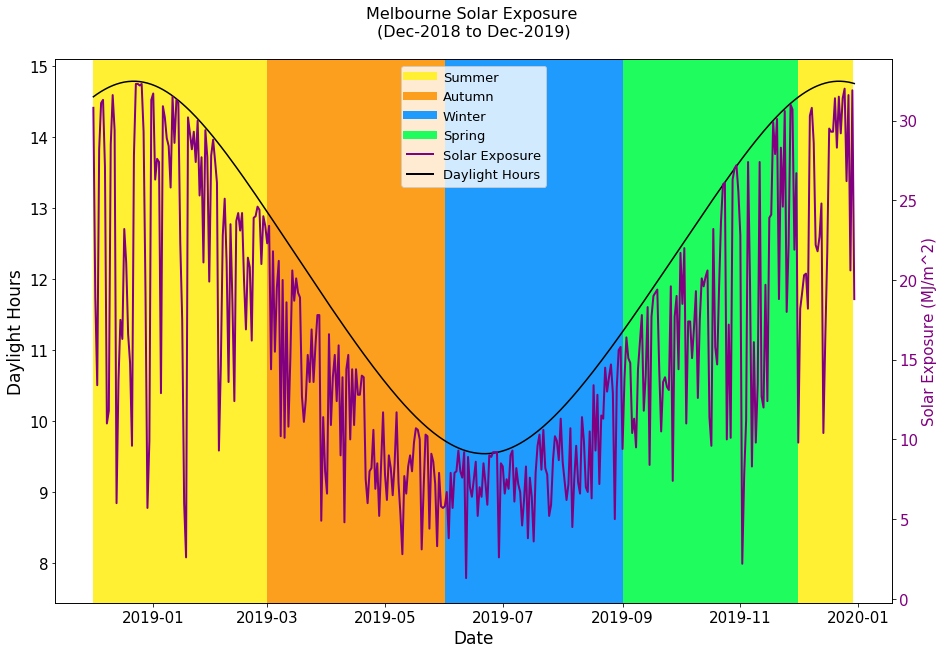

In [251]:
nights_energy_GWh = [i/1000 for i in nights_energy] # make list with GWh not MWh
fig, ax1 = plt.subplots()

fig.set_figheight(10)
fig.set_figwidth(15)

ax1.plot(dates, day_lengths, color='black')
ax1.set_title('Melbourne Solar Exposure \n(Dec-2018 to Dec-2019)\n', size=16)
ax1.set_xlabel('Date', size=17)
ax1.set_ylabel('Daylight Hours', size=17)
ax1.set_ylim([7.44,15.1])
ax1.tick_params(axis='y', labelsize=15)
ax1.tick_params(axis='x', labelsize=15)

ax1.axvspan(d1, autumn, color='#FFF033')
ax1.axvspan(autumn, winter, color='#FC9E1E')
ax1.axvspan(winter, spring, color='#1E9BFC')
ax1.axvspan(spring, summer, color='#1EFC5E')
ax1.axvspan(summer, d_last, color='#FFF033')

ax2 = ax1.twinx()

ax2.set_ylabel('Solar Exposure (MJ/m^2)', color='purple', size=15)
ax2.plot(dates, solar_energy['Solar'].iloc[:-1], color='purple', lw=2)
ax2.tick_params(axis='y', labelcolor='purple', labelsize=15)

legend_lines = [Line2D([0],[0], color='#FFF033', lw=8),
                Line2D([0],[0], color='#FC9E1E', lw=8),
                Line2D([0],[0], color='#1E9BFC', lw=8),
                Line2D([0],[0], color='#1EFC5E', lw=8),
                Line2D([0],[0], color='purple', lw=2),
                Line2D([0],[0], color='black', lw=2)]
                       
ax1.legend(legend_lines, 
           ['Summer', 'Autumn', 'Winter', 'Spring', 'Solar Exposure', 'Daylight Hours'],
           loc=9, 
           prop={'size':13})
plt.savefig('solar_exposure_year')

### Lets assume that at midnight of 01/12/18, we have a battery that was 100% full. How big would that battery have to be and how much solar power production will we need so that when we get to the most peak demand day, we dont run out of power at night?

Lets assume that when the sun rises, all solar panels achieve 100% effective power for that days solar exposure. Obviously that is not the case in real life but it is a start. 

In [78]:
VIC['Energy_demand'] = hhour_energy

In [83]:
solar_energy.tail()

Product code  Bureau of Meteorology station number  Year  Month  Day  \
10952   IDCJAC0016                                 86338  2019     12   27   
10953   IDCJAC0016                                 86338  2019     12   28   
10954   IDCJAC0016                                 86338  2019     12   29   
10955   IDCJAC0016                                 86338  2019     12   30   
10956   IDCJAC0016                                 86338  2019     12   31   

       Daily global solar exposure (MJ/m*m)  
10952                                  31.6  
10953                                  20.6  
10954                                  31.9  
10955                                  18.8  
10956                                  29.3

Lets start with the minimum amount of solar power we need to power the state when demand is at its highest. 

In [85]:
# what was the peak power demand throughout the year and when
VIC[['DATE','HOUR', 'MW']].loc[VIC['MW'].idxmax()]

DATE    2019-01-24 00:00:00
HOUR                     18
MW                     9311
Name: 13350, dtype: object

### On 24/01/2019 at 6pm, energy demand peaked at 9311MW. Lets make 10000MW our starting amount of solar power.

In [205]:
solar_power_cap = 10000

In [189]:
temp = VIC # create a temp dataframe

In [190]:
temp.reset_index(inplace=True, drop=True)

In [191]:
# add new columns
temp['solar'] = np.nan 
temp['production'] = 0*len(temp) 
temp['net_power'] = np.nan
temp['storage_level'] = 0*len(temp)

In [192]:
# add solar exposure scalar for each day
date = pd.unique(temp['DATE'])
date = pd.Series(date)
date = date.sort_values()
for i in range(len(solar_energy)):
    temp.loc[temp['DATE'] == date.iloc[i], 'solar'] = solar_energy.iloc[i]
    print(f'{i+1}/{len(solar_energy)}', end='\r')

In [193]:
# create mask for times between sunrise and sunset
daylight_mask = []
i = 0
j = 0
while i < len(temp)-1:
    x1 = temp['HOUR'].iloc[i]
    x2 = temp['HOUR'].iloc[i+1]
    if x1 == 24:
        x1 = 0
        j += 1
    sunrise = year_times[j][0]
    sunset = year_times[j][1]
    if x1 > sunrise and x2 < sunset and x1 != 0:
        daylight_mask.append(True)
    else:
        daylight_mask.append(False)
    i += 1
    print(f'{j+1}/{len(year_times)}', end='\r')   

32/396

In [194]:
is_daylight = daylight_mask
daylight_mask.append(False)
temp['is_daylight'] = daylight_mask

In [206]:
temp.loc[daylight_mask, ['production']] = 0.5*temp['solar']*solar_power_cap

In [207]:
temp['net_power'] = temp['production'] - temp['Energy_demand']

In [208]:
temp['storage_level'].iloc[0] = 60000

In [212]:
solar_power_cap = 10000
max_level = 60000
is_full_day_var = False
i = 0
while i < len(temp):
    if i > 0: 
        previous_level = temp['storage_level'].iloc[i-1]
        next_level = previous_level + temp['net_power'].iloc[i]
        if temp['is_daylight'].iloc[i-1] == True and temp['is_daylight'].iloc[i] == False: # check row before sunset 
            if previous_level == max_level: # is storage full before sunset?
                is_full_day_var = True # trigger variable
        elif temp['is_daylight'].iloc[i] == True and temp['is_daylight'].iloc[i-1] == False: # check row after sunrise
            is_full_day_var = False # reset variable at sunrise

        if next_level > max_level: # check if the storage is full
            temp['storage_level'].iloc[i] = max_level # set to max_level
            i += 1
        elif next_level < 0: # storage depleted
            if is_full_day_var == True: # if true then we need more storage
                max_level += 10000
                print(f'Increased storage: {max_level}, ({i})')
                i = 0 # start again
                temp['storage_level'].iloc[i] = max_level
                is_full_day_var == False # reset variable
            else:
                solar_power_cap += 1000 # need more solar
                print(f'Increased Solar Cap: {solar_power_cap}, ({i})')
                temp.loc[daylight_mask, ['production']] = 0.5*temp['solar']*solar_power_cap
                temp['net_power'] = temp['production'] - temp['Energy_demand']
                i = 0
                temp['storage_level'].iloc[i] = max_level
        else:
            temp['storage_level'].iloc[i] = next_level
            i += 1
        print(i, end='\r')
    else: # skip first row
        i+=1
        continue

Increased Solar Cap: 11000, (385)
Increased Solar Cap: 12000, (136)
Increased Solar Cap: 13000, (142)
Increased Solar Cap: 14000, (145)
Increased Solar Cap: 15000, (147)
Increased Solar Cap: 16000, (150)
Increased Solar Cap: 17000, (153)
Increased Solar Cap: 18000, (379)
Increased Solar Cap: 19000, (381)
Increased Solar Cap: 20000, (383)
Increased Solar Cap: 21000, (385)
Increased Solar Cap: 22000, (387)
Increased Solar Cap: 23000, (390)
Increased Solar Cap: 24000, (392)
Increased Solar Cap: 25000, (616)
Increased Solar Cap: 26000, (617)
Increased Solar Cap: 27000, (618)
Increased Solar Cap: 28000, (619)
Increased Solar Cap: 29000, (620)
Increased Solar Cap: 30000, (621)
Increased Solar Cap: 31000, (623)
Increased Solar Cap: 32000, (624)
Increased Solar Cap: 33000, (625)
Increased Solar Cap: 34000, (626)
Increased Solar Cap: 35000, (627)
Increased Solar Cap: 36000, (629)
Increased Solar Cap: 37000, (630)
Increased Solar Cap: 38000, (632)
Increased Solar Cap: 39000, (633)
Increased Sola

KeyboardInterrupt: 

In [213]:
temp.head(9350)

index REGION       DATE  HOUR    MW  Energy_demand     solar  \
0       193   VIC1 2018-12-01   0.5  4439           0.00  0.880000   
1       194   VIC1 2018-12-01   1.0  4279        2179.50  0.880000   
2       195   VIC1 2018-12-01   1.5  4148        2106.75  0.880000   
3       196   VIC1 2018-12-01   2.0  4013        2040.25  0.880000   
4       197   VIC1 2018-12-01   2.5  3926        1984.75  0.880000   
5       198   VIC1 2018-12-01   3.0  3846        1943.00  0.880000   
6       199   VIC1 2018-12-01   3.5  3783        1907.25  0.880000   
7       200   VIC1 2018-12-01   4.0  3731        1878.50  0.880000   
8       201   VIC1 2018-12-01   4.5  3777        1877.00  0.880000   
9       202   VIC1 2018-12-01   5.0  3738        1878.75  0.880000   
10      203   VIC1 2018-12-01   5.5  3822        1890.00  0.880000   
11      204   VIC1 2018-12-01   6.0  3886        1927.00  0.880000   
12      205   VIC1 2018-12-01   6.5  4023        1977.25  0.880000   
13      206   VIC1 2018-12-01   7.0  4069        2023.00  0.880000   
14      207   VIC1 2018-12-01   7.5  4006        2018.75  0.880000   
15      208   VIC1 2018-12-01   8.0  4007        2003.25  0.880000   
16      209   VIC1 2018-12-01   8.5  4042        2012.25  0.880000   
17      210   VIC1 2018-12-01   9.0  3969        2002.75  0.880000   
18      211   VIC1 2018-12-01   9.5  3935        1976.00  0.880000   
19      212   VIC1 2018-12-01  10.0  3898        1958.25  0.880000   
20      213   VIC1 2018-12-01  10.5  3833        1932.75  0.880000   
21      214   VIC1 2018-12-01  11.0  3782        1903.75  0.880000   
22      215   VIC1 2018-12-01  11.5  3778        1890.00  0.880000   
23      216   VIC1 2018-12-01  12.0  3744        1880.50  0.880000   
24      217   VIC1 2018-12-01  12.5  3749        1873.25  0.880000   
25      218   VIC1 2018-12-01  13.0  3788        1884.25  0.880000   
26      219   VIC1 2018-12-01  13.5  3899        1921.75  0.880000   
27      220   VIC1 2018-12-01  14.0  4084        1995.75  0.880000   
28      221   VIC1 2018-12-01  14.5  4241        2081.25  0.880000   
29      222   VIC1 2018-12-01  15.0  4347        2147.00  0.880000   
30      223   VIC1 2018-12-01  15.5  4452        2199.75  0.880000   
31      224   VIC1 2018-12-01  16.0  4609        2265.25  0.880000   
32      225   VIC1 2018-12-01  16.5  4746        2338.75  0.880000   
33      226   VIC1 2018-12-01  17.0  4909        2413.75  0.880000   
34      227   VIC1 2018-12-01  17.5  4980        2472.25  0.880000   
35      228   VIC1 2018-12-01  18.0  4985        2491.25  0.880000   
36      229   VIC1 2018-12-01  18.5  4920        2476.25  0.880000   
37      230   VIC1 2018-12-01  19.0  4872        2448.00  0.880000   
38      231   VIC1 2018-12-01  19.5  4911        2445.75  0.880000   
39      232   VIC1 2018-12-01  20.0  4910        2455.25  0.880000   
40      233   VIC1 2018-12-01  20.5  4869        2444.75  0.880000   
41      234   VIC1 2018-12-01  21.0  4743        2403.00  0.880000   
42      235   VIC1 2018-12-01  21.5  4611        2338.50  0.880000   
43      236   VIC1 2018-12-01  22.0  4441        2263.00  0.880000   
44      237   VIC1 2018-12-01  22.5  4354        2198.75  0.880000   
45      238   VIC1 2018-12-01  23.0  4258        2153.00  0.880000   
46      239   VIC1 2018-12-01  23.5  4366        2156.00  0.880000   
47      240   VIC1 2018-12-01  24.0  4307        2168.25  0.880000   
48      436   VIC1 2018-12-02   0.5  4108        2103.75  0.540000   
49      437   VIC1 2018-12-02   1.0  3919        2006.75  0.540000   
50      438   VIC1 2018-12-02   1.5  3774        1923.25  0.540000   
51      439   VIC1 2018-12-02   2.0  3584        1839.50  0.540000   
52      440   VIC1 2018-12-02   2.5  3512        1774.00  0.540000   
53      441   VIC1 2018-12-02   3.0  3423        1733.75  0.540000   
54      442   VIC1 2018-12-02   3.5  3420        1710.75  0.540000   
55      443   VIC1 2018-12-02   4.0  3365        1696.25  0.540000   
56      444   VI